Load importance scores. In this example, these are the importance scores for the positive examples for task 0 in the talgata simulation from the deeplift paper (analysis is done on the test set)

File talgata_task0_positives_scores.npy exists already
(236, 200, 4)


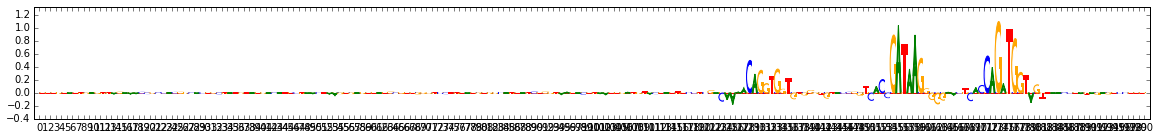

In [1]:
!./grab_data.sh

%matplotlib inline
import numpy as np
scores = np.load("talgata_task0_positives_scores.npy")
onehot_seq = (np.abs(scores) > 0)*1.0
print(scores.shape)
from modisco.visualization import viz_sequence
viz_sequence.plot_weights(scores[0])

In [2]:
from modisco import core
score_track = core.DataTrack(name="scores", fwd_tracks=scores,
                             rev_tracks=scores[:,::-1,::-1],
                             has_pos_axis=True)
onehot_track = core.DataTrack(name="sequence", fwd_tracks=onehot_seq,
                               rev_tracks=onehot_seq[:,::-1,::-1],
                               has_pos_axis=True)
track_set = core.TrackSet(data_tracks=[score_track, onehot_track])

In [3]:
from modisco import coordproducers
seqlets = track_set.create_seqlets(track_names=["scores","sequence"],
                                   coords=coordproducers.FixedWindowAroundChunks(
                                            sliding=7, flank=2,
                                            suppress=3, min_ratio=0.5,
                                            max_seqlets_per_seq=5,
                                            batch_size=50, progress_update=5000,
                                            verbose=True).get_coords(np.sum(scores, axis=2)))
print(len(seqlets))
#sort the seqlets by strength
seqlets = sorted(seqlets, key=lambda x: -np.sum(x["scores"].fwd))

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29



Compiling functions
Computing window sums
('Done', 0)
Identifying seqlet coordinates
('Done', 0)
('Done', 0)
('Done', 0)
('Done', 0)
('Done', 0)
792


Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN 5005)


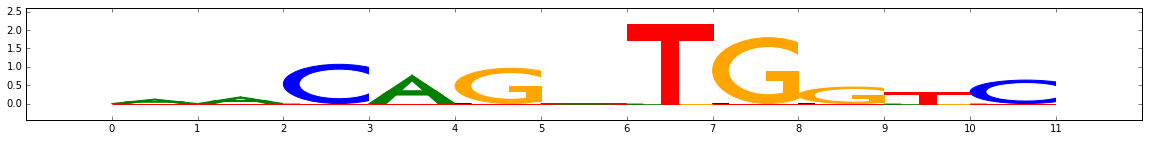

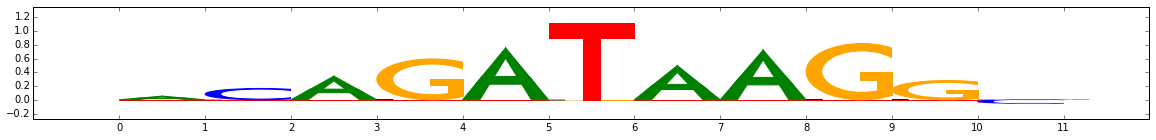

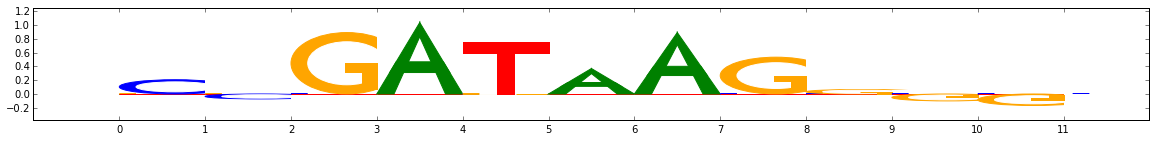

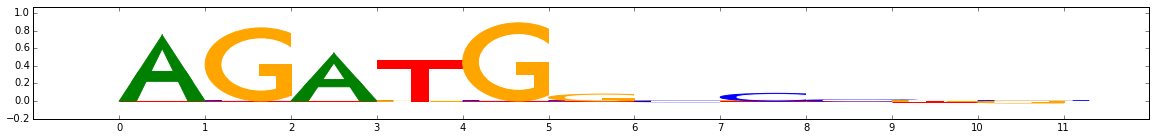

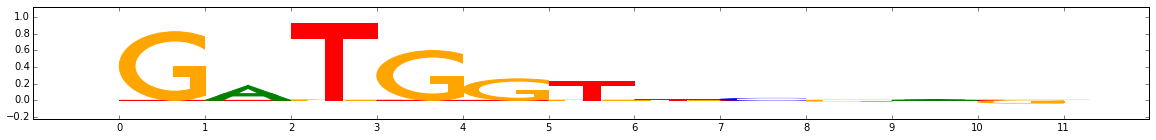

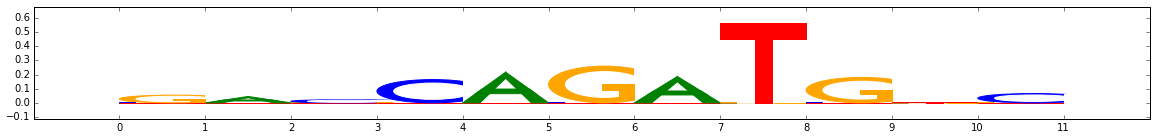

In [4]:
#print 5 seqlets drawn from across the range, as a sanity check
for i in range(0,len(seqlets),int(len(seqlets)/5)):
    viz_sequence.plot_weights(seqlets[i]["scores"].fwd)

In [5]:
from modisco import affinitymat as affmat
affinity_mat = affmat.MaxCrossCorrAffinityMatrixFromSeqlets(                    
                    track_names=["scores"],                                     
                    normalizer=affmat.MeanNormalizer().chain(affmat.MagnitudeNormalizer()),   
                    min_overlap=0.3).get_affinity_matrix(seqlets)

(792, 11, 4)
('On filters', 0, 'to', 22727)
('Done', 0)
(792, 11, 4)
('On filters', 0, 'to', 22727)
('Done', 0)


In [8]:
from modisco.cluster import core as mclust
cluster_results = mclust.PhenographCluster().cluster(affinity_mat=affinity_mat)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.257163047791 seconds
Jaccard graph constructed in 0.122400999069 seconds
Wrote graph to binary file in 0.0311379432678 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.811297
Louvain completed 21 runs in 0.400959968567 seconds
PhenoGraph complete in 0.817122936249 seconds


In [9]:
from collections import defaultdict
cluster_to_seqlets = defaultdict(list)
for cluster_val, seqlet in zip(cluster_results.cluster_indices, seqlets):
    cluster_to_seqlets[cluster_val].append(seqlet)

('ON cluster ', 0)


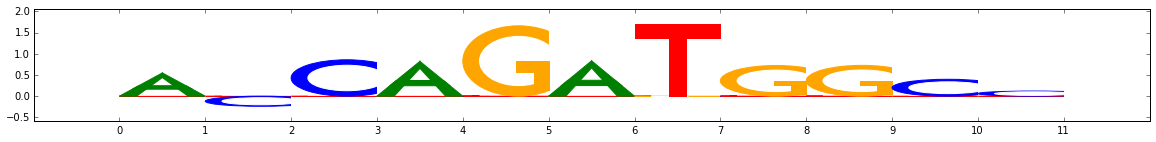

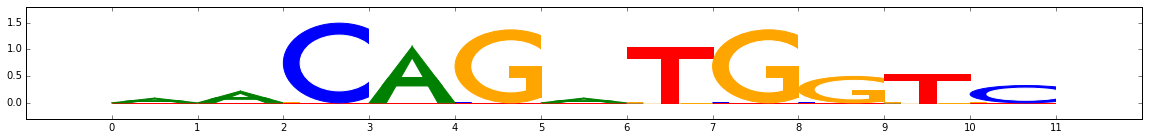

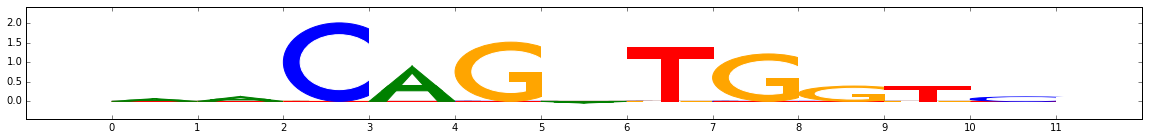

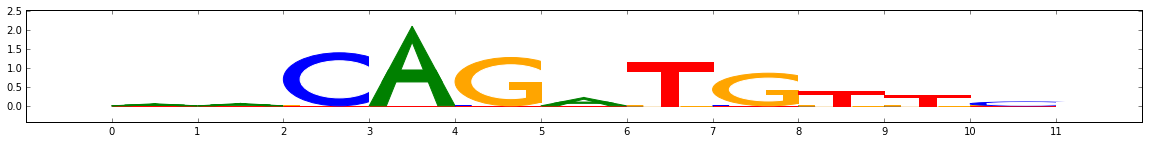

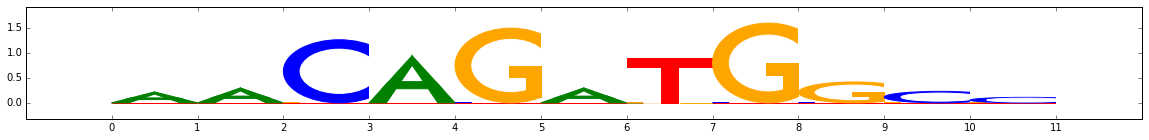

('ON cluster ', 1)


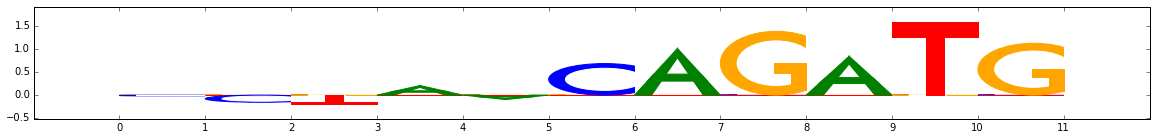

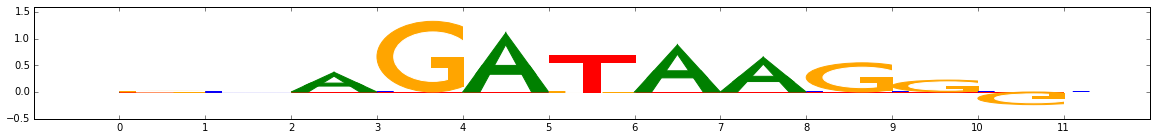

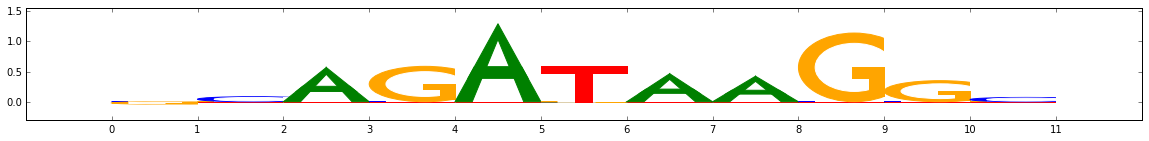

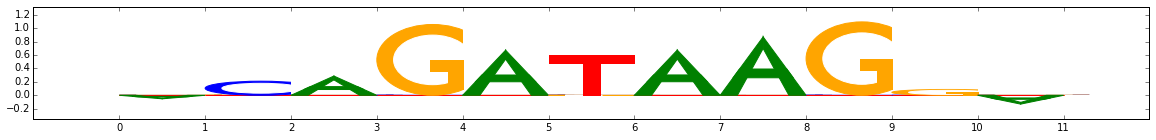

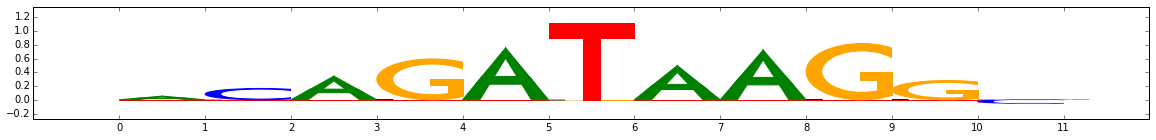

('ON cluster ', 2)


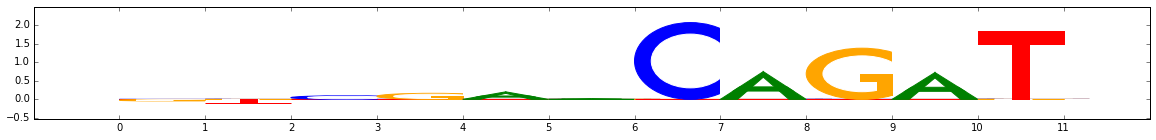

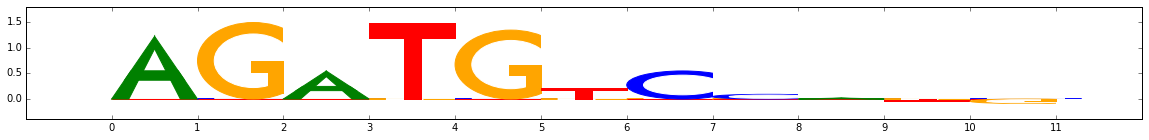

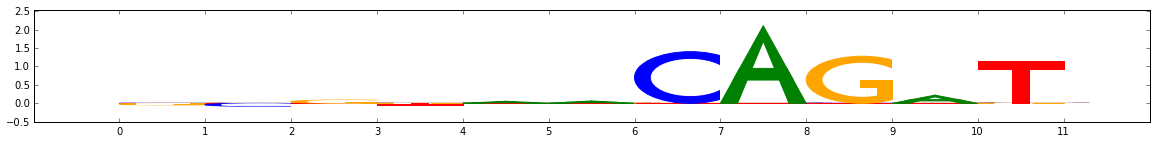

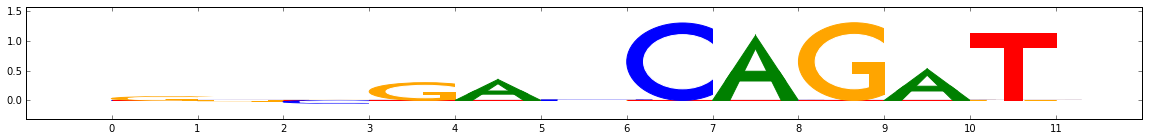

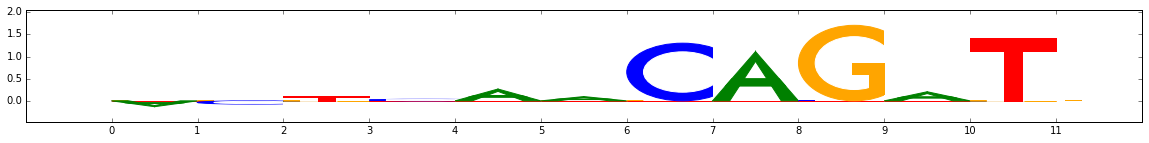

('ON cluster ', 3)


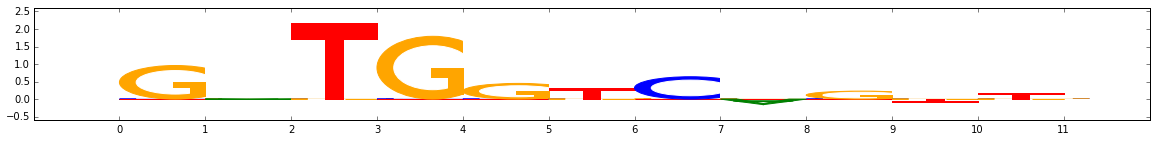

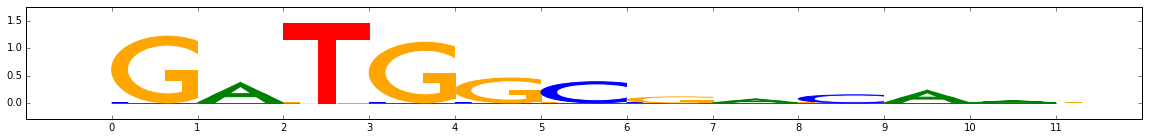

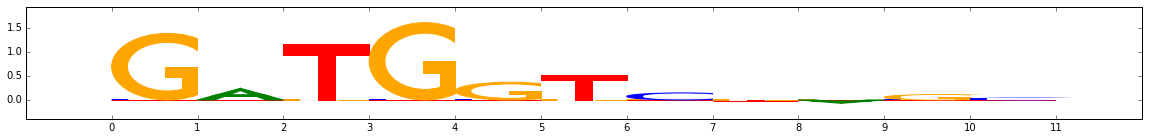

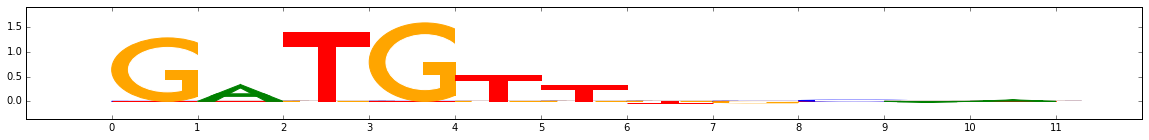

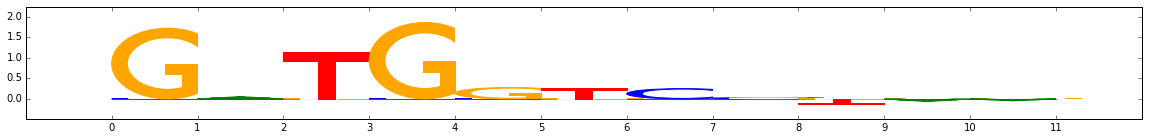

('ON cluster ', 4)


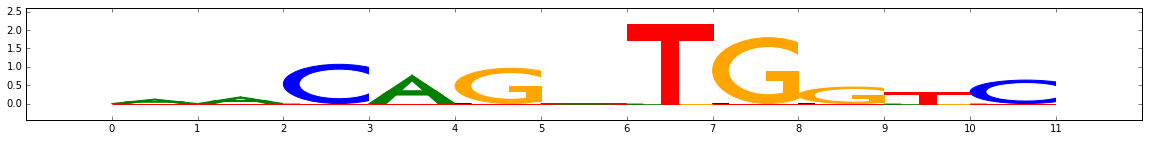

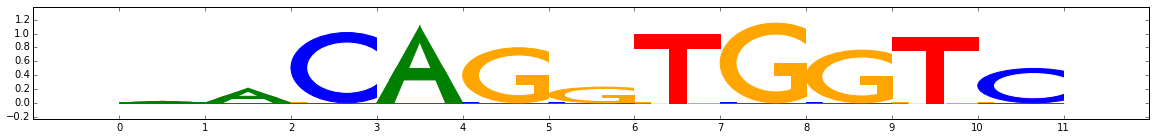

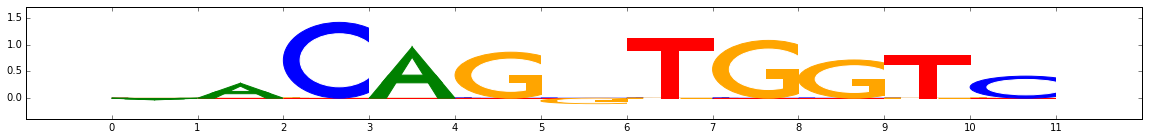

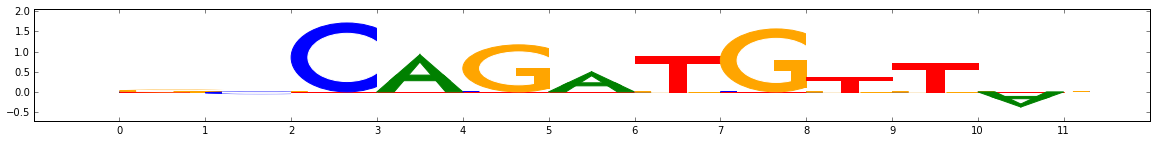

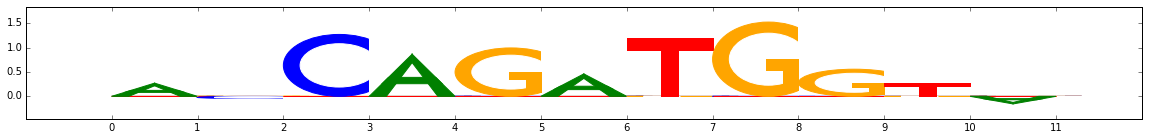

('ON cluster ', 5)


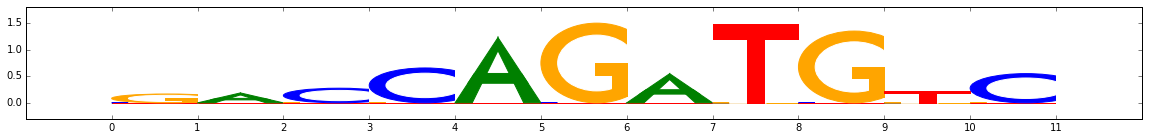

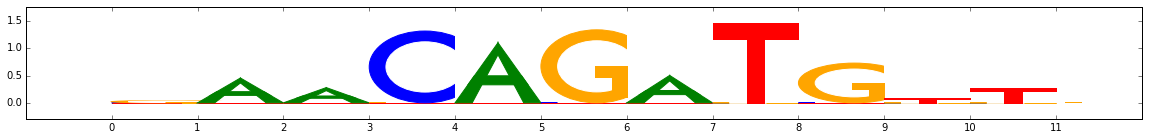

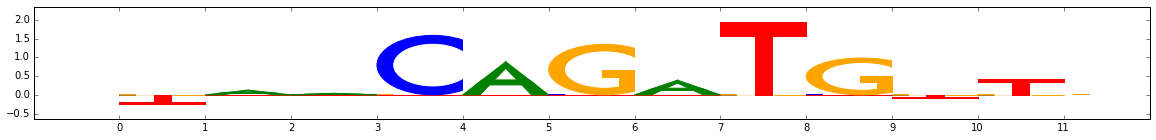

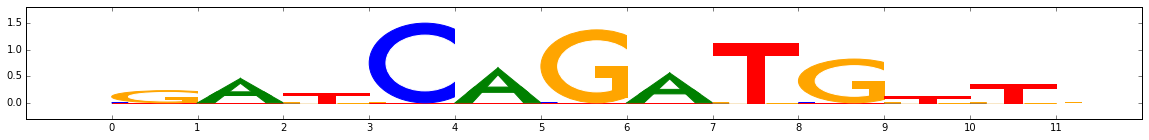

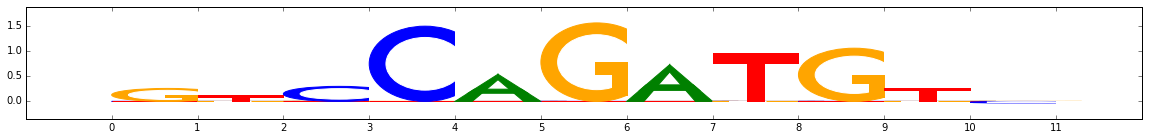

('ON cluster ', 6)


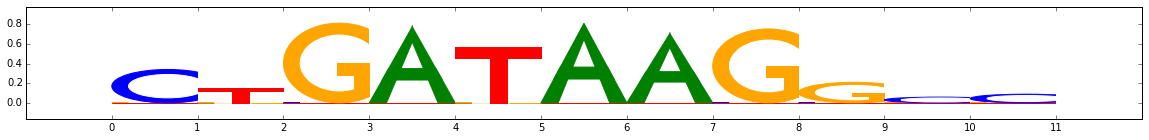

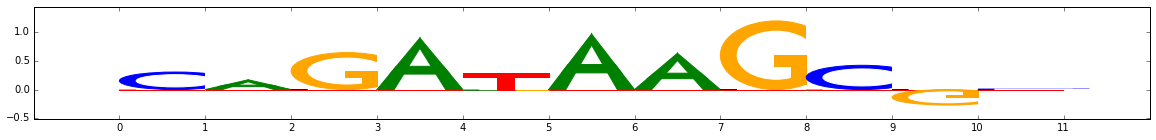

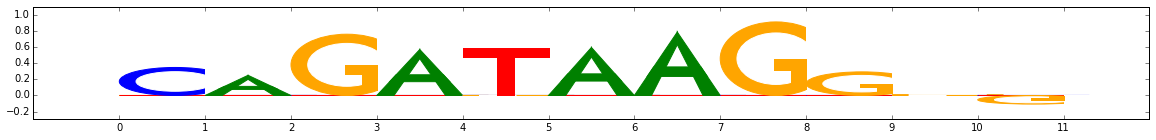

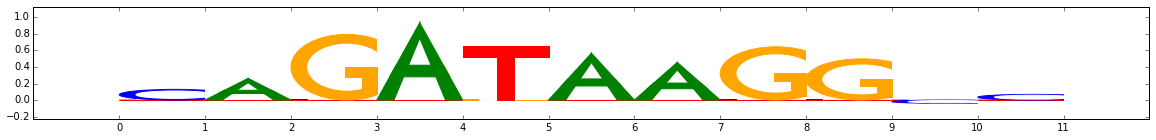

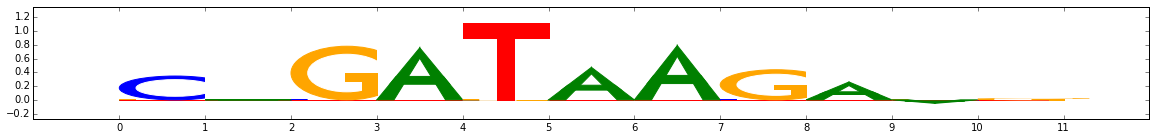

In [10]:
for i in range(max(cluster_results.cluster_indices)):
    print("ON cluster ",i)
    for j in range(5):
        viz_sequence.plot_weights(cluster_to_seqlets[i][j]["scores"].fwd)

No colors supplied, so autogen'd as:
(0, (0, 1.0, 0.0))
(1, (0, 0.9444444444444444, 0.05555555555555555))
(2, (0, 0.4722222222222222, 0.5277777777777778))
(3, (0.0, 0, 1.0))
(4, (0.05555555555555555, 0, 0.9444444444444444))
(5, (0.5277777777777778, 0, 0.4722222222222222))
(6, (1.0, 0.0, 0))
(7, (0.9444444444444444, 0.05555555555555558, 0))


/Users/avantishrikumar/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


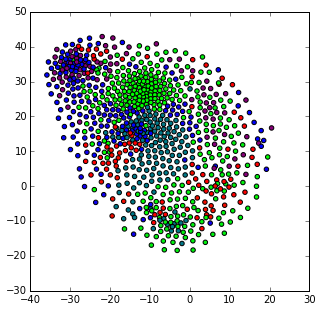

In [34]:
from modisco.visualization import tsne
reload(tsne)
import modisco
reload(modisco.visualization.matplotlibhelpers)

embedding = tsne.get_tsne_embedding(affinity_mat=affinity_mat, perplexity=30)
tsne.color_tsne_embedding_by_clustering(embedding=embedding, clusters=cluster_results.cluster_indices)

In [27]:
from sklearn import manifold